In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, InputLayer
import random
import os

import math

import pylab as p
import seaborn as sns
from datetime import datetime, timedelta
import string
from sklearn.preprocessing import OneHotEncoder

In [67]:
file_path_volts1 = r".\dataset\H2\Tagged_Training_06_13_1339570801\LF1V.csv"
file_path_amps1 = r".\dataset\H2\Tagged_Training_06_13_1339570801\LF1I.csv"
file_path_time_ticks1 = r".\dataset\H2\Tagged_Training_06_13_1339570801\TimeTicks1.csv"

file_path_volts2 = r".\dataset\H2\Tagged_Training_06_13_1339570801\LF2V.csv"
file_path_amps2 = r".\dataset\H2\Tagged_Training_06_13_1339570801\LF2I.csv"
file_path_time_ticks2 = r".\dataset\H2\Tagged_Training_06_13_1339570801\TimeTicks2.csv"

LF1V = pd.read_csv(file_path_volts1)
LF1I = pd.read_csv(file_path_amps1)
time_ticks1 = pd.read_csv(file_path_time_ticks1)

LF2V = pd.read_csv(file_path_volts2)
LF2I = pd.read_csv(file_path_amps2)
time_ticks2 = pd.read_csv(file_path_time_ticks2)

In [68]:
LF1V = np.array(LF1V)
LF1I = np.array(LF1I)
LF1V = np.array([[complex(y.replace("i", "j")) for y in x] for x in LF1V])
LF1I = np.array([[complex(y.replace("i", "j")) for y in x] for x in LF1I])

LF2V = np.array(LF2V)
LF2I = np.array(LF2I)
LF2V = np.array([[complex(y.replace("i", "j")) for y in x] for x in LF2V])
LF2I = np.array([[complex(y.replace("i", "j")) for y in x] for x in LF2I])

In [69]:
L1_P = LF1V * np.conjugate(LF1I)
L2_P = LF2V * np.conjugate(LF2I)

L1_ComplexPower = np.sum(L1_P, axis=1)
L2_ComplexPower = np.sum(L2_P, axis=1)

L1_real = np.real(L1_ComplexPower)
L1_imag = np.imag(L1_ComplexPower)
L1_app = np.abs(L1_ComplexPower)

L2_real = np.real(L2_ComplexPower)
L2_imag = np.imag(L2_ComplexPower)
L2_app = np.abs(L2_ComplexPower)

L1_Pf = np.cos(np.angle(L1_P[:, 0]))
L2_Pf = np.cos(np.angle(L2_P[:, 0]))

L1_actual_power = L1_real * L1_Pf
L2_actual_power = L2_real * L2_Pf

power = L1_actual_power + L2_actual_power[:len(L1_actual_power)]

In [70]:
time_ticks1_datetime = pd.to_datetime(time_ticks1.iloc[:, 0], unit='s')
time_ticks1_np = np.array(time_ticks1)
TS1_real = np.array(time_ticks1_datetime)

time_ticks2_datetime = pd.to_datetime(time_ticks2.iloc[:, 0], unit='s')
TS2_real = np.array(time_ticks2_datetime)

# Event detection

### Smooth the data a little bit

In [71]:
def moving_average(array, window):
    moving_avg = np.convolve(array, np.ones(window) / window, mode='valid')
    return moving_avg

In [72]:
smooth_data = moving_average(power, 5)
print(smooth_data)

[351.06978502 351.27970442 350.68793894 ... 388.01590095 387.65120538
 387.78713076]


### Normalize the data

In [73]:
def normalize(array):
    min_val = np.min(array)
    max_val = np.max(array)
    normalized_array = (array - min_val) / (max_val - min_val)
    return normalized_array

In [74]:
normalized_data = normalize(smooth_data)
print(normalized_data)

[0.0387974  0.03884097 0.03871816 ... 0.04646519 0.0463895  0.04641771]


### CUSUM

In [75]:
def detect_cusum(array, threshold=1, drift=0):
    sum_positive = np.zeros(array.size)
    sum_negative = np.zeros(array.size)
    event_index = np.array([[], [], []], dtype=int)

    for i in range(1, array.size):
        sum = array[i] - array[i-1]

        # sums for positive/negative changes
        sum_positive[i] = max(0, sum_positive[i-1] + sum - drift)
        sum_negative[i] = max(0, sum_negative[i-1] - sum - drift)

        # if a change is detected
        if sum_positive[i] > threshold or sum_negative[i] > threshold:
            event_index = np.append(event_index, i)
            sum_positive[i], sum_negative[i] = 0, 0

    return event_index

In [76]:
events = detect_cusum(normalized_data, threshold=0.015, drift=0.001)

### Since this algorithm tends to over detect, we have to clean the output a little bit

In [77]:
def filter_close_events(event_indices, min_separation):
    filtered_indices = [event_indices[0]]

    for i in range(1, len(event_indices)):
        if event_indices[i] - event_indices[i - 1] >= min_separation:
            # If the time separation is greater than or equal to the threshold, keep the event
            filtered_indices.append(event_indices[i])

    return np.array(filtered_indices)

In [78]:
clean_events = filter_close_events(events, 24)
print(clean_events.shape)

(816,)


# Visualizing data

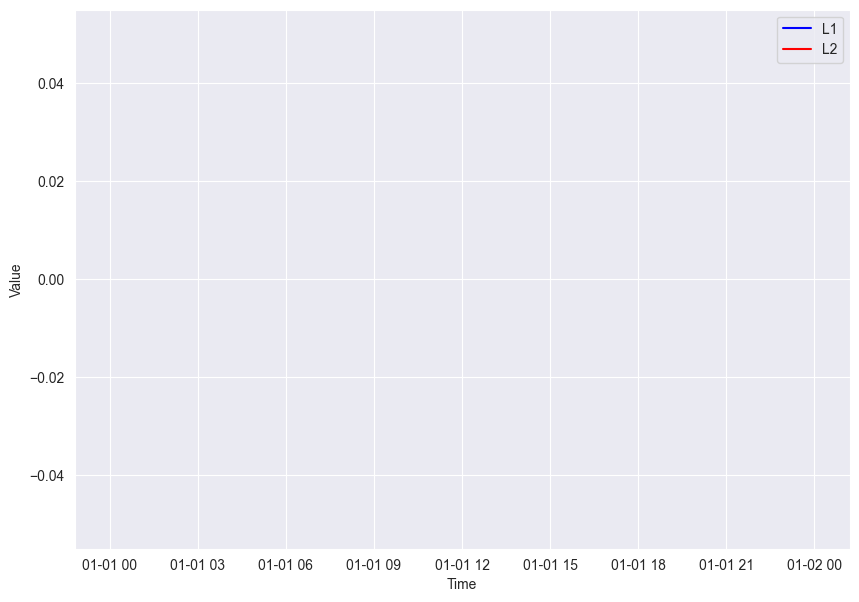

In [80]:
# Example date: 2023-10-10 12:00:00
def zoomIn(start_time: string, end_time: string, time_ticks):
    date_format = "%Y-%m-%d %H:%M:%S"
    # We add two hours because for some reason the start/end index are two hours short
    start_time = (datetime.strptime(start_time, date_format) + timedelta(hours=1)).timestamp()
    end_time = (datetime.strptime(end_time, date_format) + timedelta(hours=1)).timestamp()

    start_index = -1
    end_index = -1
    for index in range(len(TS1_real)):
        if time_ticks[index] > start_time and start_index == -1:
            start_index = index
        if time_ticks[index] > end_time and end_index == -1:
            end_index = index
    return start_index, end_index


start_index, end_index = zoomIn("2013-06-13 14:45:00", "2013-06-13 20:45:10", time_ticks1_np)
plt.figure(figsize=(10, 7))

#This plots total power consumption (zoomed in)
# plt.plot(TS2_real[start_index:end_index], power[start_index:end_index], linestyle='-', color='g', label='phase 1 + phase 2')

#This plots total power consumption
# plt.plot(TS1_real, power, linestyle='-', color='g', label='phase 1 + phase 2')

# This plots phase 1 and phase 2 separately (zoomed in)
plt.plot(TS1_real[start_index:end_index], L1_actual_power[start_index:end_index], linestyle='-', color='b', label='L1')
plt.plot(TS2_real[start_index:end_index], L2_actual_power[start_index:end_index], linestyle='-', color='r', label='L2')

# This plots phase 1 and phase 2 separately (whole thing)
# plt.plot(TS1_real, L1_actual_power, linestyle='-', color='b', label='L1')
# plt.plot(TS2_real, L2_actual_power, linestyle='-', color='r', label='L2')

# plt.plot(TS1_real[start_index:end_index], power[start_index:end_index], linestyle='-', color='b', label='smooth')
event_times = [TS1_real[i] for i in events if start_index <= i <= end_index]
for event_time in event_times:
    plt.axvline(event_time, color='g', linestyle='--')
# plt.plot(TS1_real, power, linestyle='-', color='r', label='power')

plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

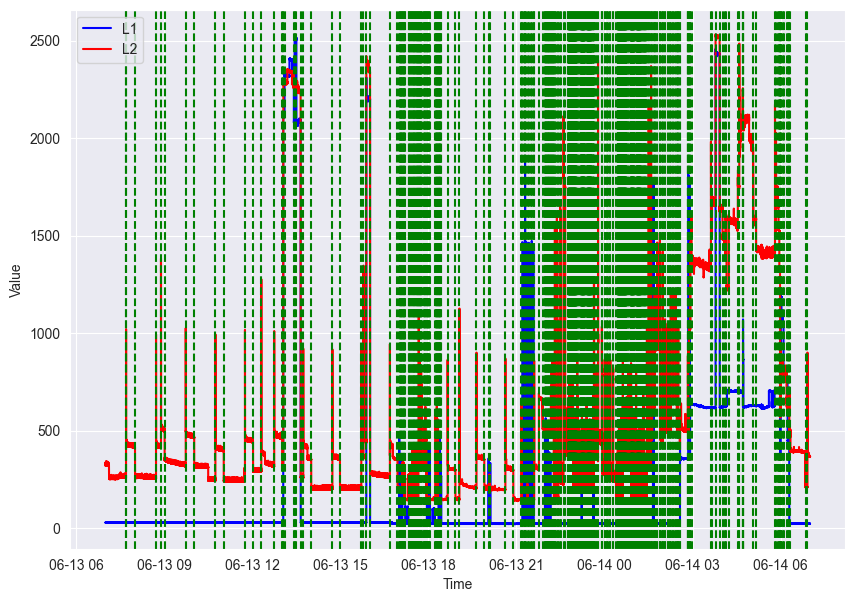

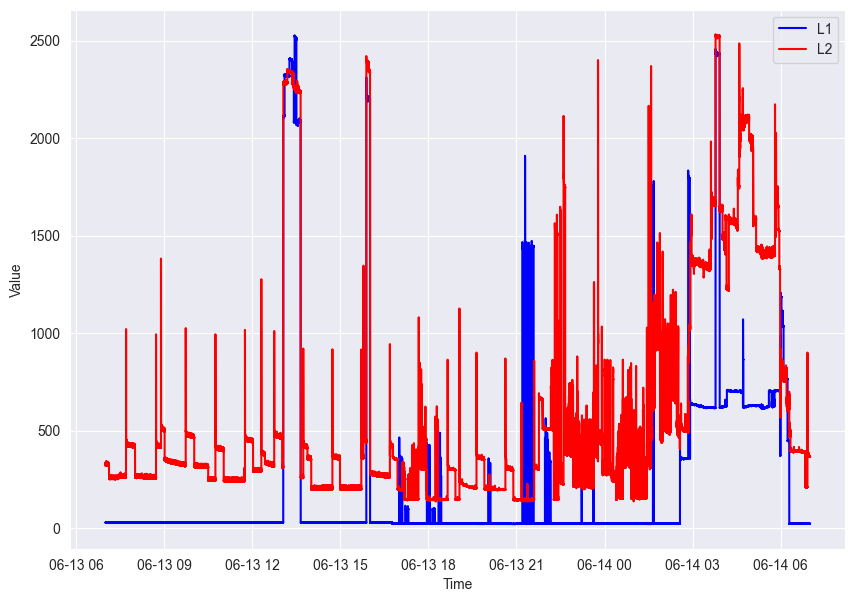

In [81]:
plt.figure(figsize=(10, 7))
plt.plot(TS1_real, L1_actual_power, linestyle='-', color='b', label='L1')
plt.plot(TS2_real, L2_actual_power, linestyle='-', color='r', label='L2')
# event_times = [TS1_real[i] for i in clean_events if start_index <= i <= end_index]
event_times = [TS1_real[i] for i in clean_events]
for event_time in event_times:
    plt.axvline(event_time, color='g', linestyle='--')
# plt.plot(TS1_real, power, linestyle='-', color='r', label='power')

plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 7))
plt.plot(TS1_real, L1_actual_power, linestyle='-', color='b', label='L1')
plt.plot(TS2_real, L2_actual_power, linestyle='-', color='r', label='L2')
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

# Working on the model

###

In [83]:
normalized_phase1 = normalize(L1_actual_power)
normalized_phase2 = normalize(L2_actual_power)

###